In [1]:
!pip install tensorflow

In [2]:
!pip install torch torchvision torchaudio

# Import library

In [3]:
# import system libs 
import os
import itertools

# import data handling tools 

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Concatenate, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Defining Data Paths and Creating DataFrames

In [4]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe 
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# Data Generation for Image Classification with Data Augmentation

In [5]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (164, 164)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

# Displaying Sample Images with Class Labels from a Generator

In [6]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

# Visualizing Training and Validation loss and accuracy

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

# Custom Confusion Matrix Plotting

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (5, 5))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
        print(cm)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
            plt.tight_layout()
            plt.ylabel('Actual Label')
            plt.xlabel('Predicted Label')

# Loading Data, Generating Data, and Creating Dataframes

Found 1843 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.


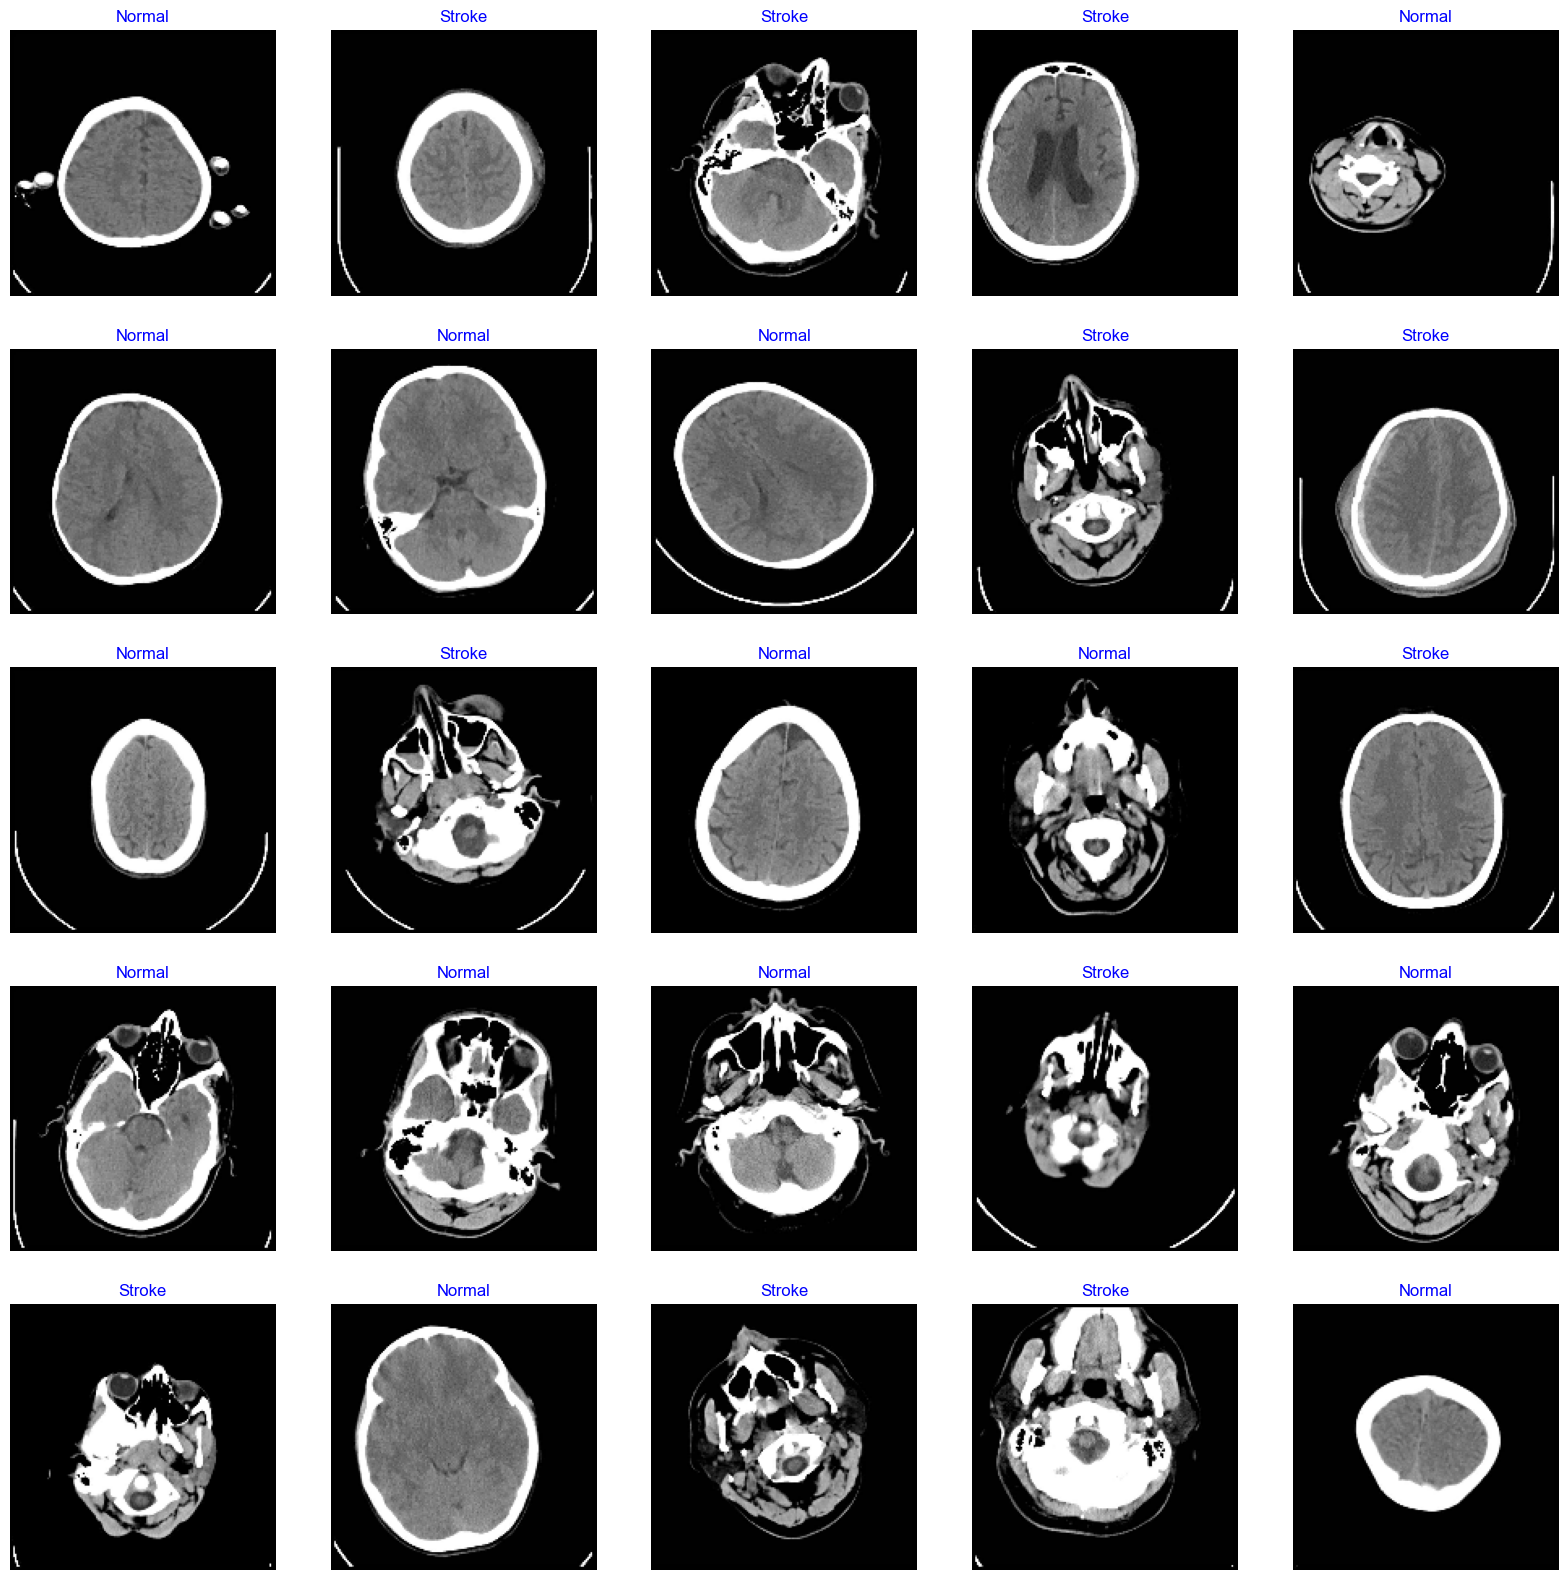

In [9]:
# Get Dataframes
train_dir = r'D:\CSE499\CSE499B\Train'
valid_dir = r'D:\CSE499\CSE499B\Validation'
test_dir = r'D:\CSE499\CSE499B\Test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 64
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization

# Define input size
img_size = (164, 164, 3)

# Create the DenseNet121 base model (pre-trained on ImageNet)
base_model = DenseNet121(input_shape=img_size, include_top=False, weights='imagenet')

# Add custom classification layers with BatchNormalizzation
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 164, 164, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 170, 170, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 82, 82, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 82, 82, 64)   256         ['conv1/conv[0][0]']         

In [11]:
history = model.fit(x= train_gen, epochs= 30, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False, initial_epoch= 0)

Epoch 1/30
29/29 [==============================] - 409s 13s/step - loss: 0.7311 - accuracy: 0.6831 - val_loss: 2.7513 - val_accuracy: 0.7025
Epoch 2/30
29/29 [==============================] - 353s 12s/step - loss: 0.3446 - accuracy: 0.8388 - val_loss: 2.3247 - val_accuracy: 0.7025
Epoch 3/30
29/29 [==============================] - 356s 12s/step - loss: 0.2046 - accuracy: 0.9235 - val_loss: 3.4237 - val_accuracy: 0.7025
Epoch 4/30
29/29 [==============================] - 364s 13s/step - loss: 0.1193 - accuracy: 0.9550 - val_loss: 2.3012 - val_accuracy: 0.7025
Epoch 5/30
29/29 [==============================] - 364s 13s/step - loss: 0.1890 - accuracy: 0.9170 - val_loss: 2.1337 - val_accuracy: 0.7071
Epoch 6/30
29/29 [==============================] - 364s 13s/step - loss: 0.1380 - accuracy: 0.9463 - val_loss: 2.5143 - val_accuracy: 0.7140
Epoch 7/30
29/29 [==============================] - 362s 12s/step - loss: 0.0850 - accuracy: 0.9707 - val_loss: 1.3919 - val_accuracy: 0.7574
Epoch 

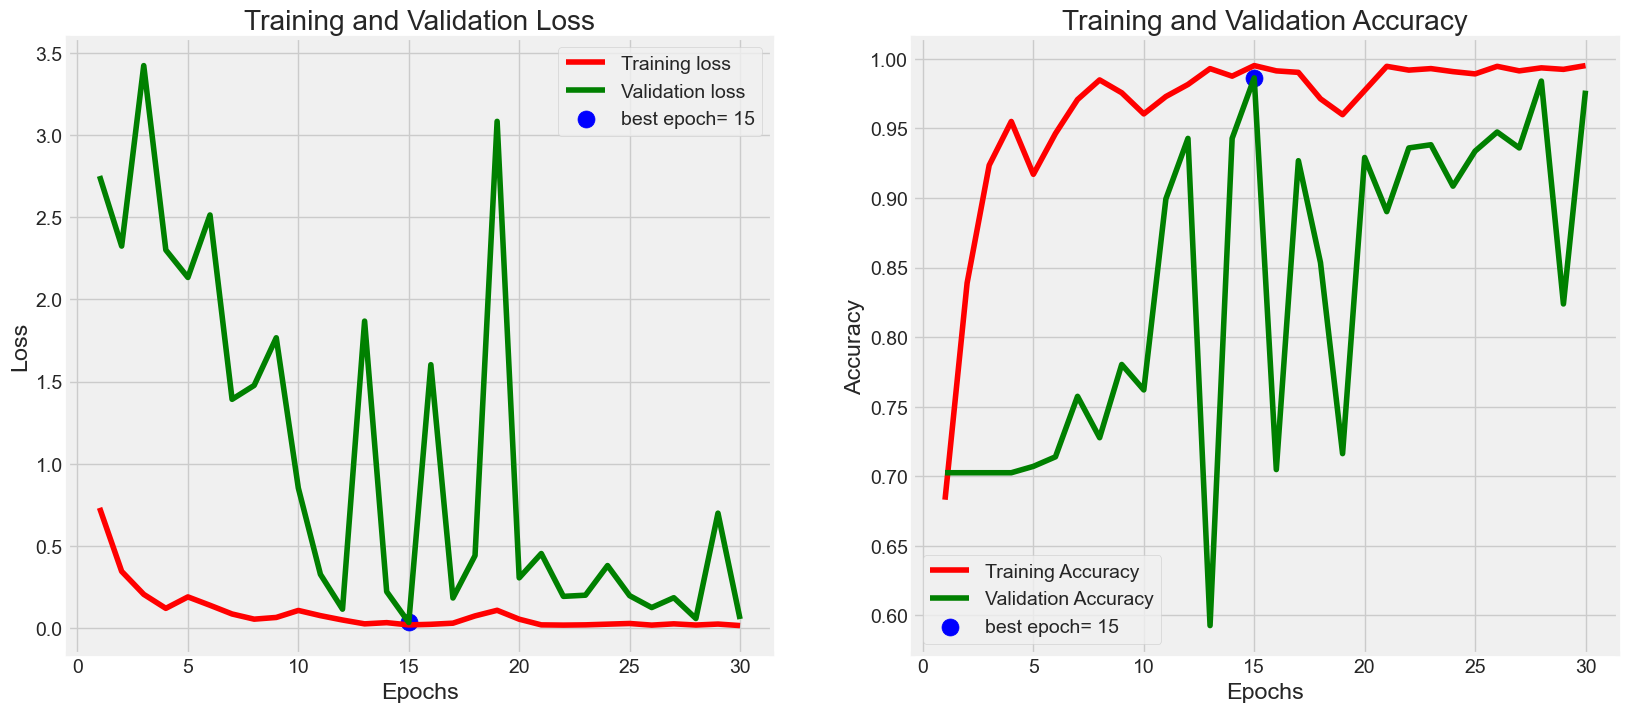

In [12]:
plot_training(history)

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 10s 2s/step - loss: 0.0515 - accuracy: 0.9787
Train Loss:  0.01180495135486126
Train Accuracy:  0.996874988079071
--------------------
Validation Loss:  0.07241380214691162
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.051494866609573364
Test Accuracy:  0.978723406791687


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confusion Matrix, Without Normalization
[[156   1]
 [  4  74]]
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       157
      Stroke       0.99      0.95      0.97        78

    accuracy                           0.98       235
   macro avg       0.98      0.97      0.98       235
weighted avg       0.98      0.98      0.98       235



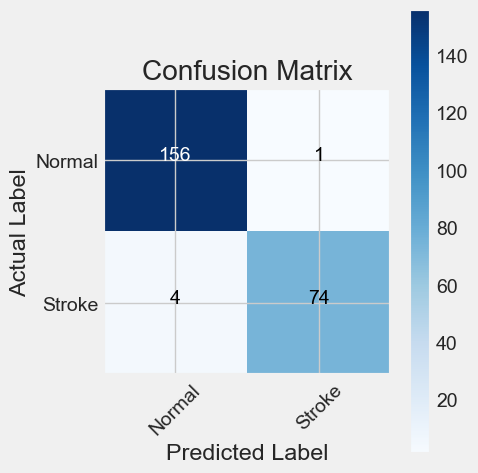

In [15]:
target_names = ['Normal', 'Stroke']

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))